### 定义一个类用来解决求两个多边形之间最近的距离
1. **分为如下几种情况进行讨论：**
    - 如果两个多边形相交但不相互包含，最短距离为0
    - 如果两个多边形相互包含和两个多边形不相交则找到一个多边形的所有顶点到另外一个多边形边之间的最短距离，这个最短的距离就是两个多边形之间的最短距离
        - 这里需要区分的是我们求的是点到线段的最短距离与点到直线的最短距离之间是有一定的差别的
        - 点到线段的距离要分为三种情况进行讨论
            - 点到线段的垂足在线段上：点到线段的最短距离即为点到直线的最短距离
            - 点到线段的垂足不线段上，而是在线段的延长线上：此时点到线段的最短距离是点到线段两端的端点的距离的较小值
2. **计算点到线段的最短距离**

    如果要计算点I(xi, yi)到线段[A, B]的最短距离，其中A的坐标为(xa, ya)，B的坐标为(xb, yb)
    
    首先把线段AB所在的直线方程用参数化表示如下：
    
    ```x = (xb-xa)*k + xa```
    
    ```y = (yb-ya)*k + ya```

    假设点I在线段AB所在直线上的投影点为P，为了得到P点的坐标我们首先将点到直线上所有点的长度用参数k表示为

    ```d = a*k^2+b*k```

    ```a = (xa-xb)^2+(ya-yb)^2```

    ```b = 2((xa-xb)(xa-xi)+(ya-yb)(ya-yi))```

    得到P对应的参数k为k=-b/(2a)，分为如下几种情况进行讨论

    if k < 0: P点落在A点之前，此时最小距离为dmin = distance(I, A)

    if k > 1: P点落在B点之后，此时最小距离为dmin = distance(I, B)

    if 0 < k < 1: P点落在线段AB上，此时最小距离为dmin = distance(I, P)
3. **计算两个多边形之间的最短距离的实际应用**
    - 计算地块内建筑之间的距离是否满足消防间距的要求
    - 计算地块内建筑与地块边界之间的距离是否满足建筑红线的要求
4. 本python代码是基于repository中matlab代码修改的，最初的解决方案源于该matlab代码，该matlab代码来源于matlab中文论坛上面的一个答主的解决方案，[链接在此](https://www.ilovematlab.cn/thread-20508-1-1.html?_dsign=af3fb928)
5. **代码经过严格的测试和验证能确保同样的输入数据python代码的结果和matlab代码的结果是吻合的，matlab代码一个很大的优点是可以对两个polygon的最短的距离进行可视化**
    


- 导入各种需要的包和库

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np 


- 定义两个多边形之间最短距离的类

In [2]:
class min_dis_between_two_polygon(object):
    '''
    输入数据：
    p1、p2: Polygon数据类型（坐标系需要是笛卡尔坐标系-以米为单位，如果是经纬度坐标系则需要转换为笛卡尔坐标系）
    '''
    def __init__(self, p1, p2):  # 初始化需要输入的数据
        # p1和p2表示两个polygon的数据
        self.p1 = p1 
        self.p2 = p2
        self.p1_coords = np.array(p1.boundary.coords)
        self.p2_coords = np.array(p2.boundary.coords)

    def min_dis_between_point_segment(self, point_set, segment_set):
        # point_set表示p2的闭合的所有坐标点，数据类型为np.array的形式
        # segment_set表示p1的闭合的所有坐标点

        # 获得p1中每个线段的长度
        dP1x = np.diff(segment_set[:, 0])  # 所有点横坐标的差值
        dP1y = np.diff(segment_set[:, 1])  # 所有点纵坐标的差值
        sdP12 = dP1x**2 + dP1y**2  # 记录每条线段的长度
        if any(sdP12 == 0):
            print('多边形的坐标点中至少有两个重叠的点！')
        K1 = np.zeros((len(dP1x), len(point_set)))
        D1 = np.zeros((len(dP1x), len(point_set)))
        
        # 遍历多边形上的每条边
        for i in range(len(segment_set)-1):
            k = -(dP1x[i]*(segment_set[i, 0]-point_set[:, 0])+dP1y[i]*(segment_set[i, 1]-point_set[:, 1]))/sdP12[i]
            # 对k分三种情况进行讨论
            I1 = k < 0
            I2 = k > 1
            # I = not (I1 or I2)  # 这里要进行变形
            I = list(map(lambda x, y: not(x or y), I1, I2))
            # 三种距离的计算
            D1[i, I1] = (point_set[I1, 0]-segment_set[i, 0])**2 + (point_set[I1, 1]-segment_set[i, 1])**2
            D1[i, I2] = (point_set[I2, 0]-segment_set[i+1, 0])**2 + (point_set[I2, 1]-segment_set[i+1, 1])**2
            D1[i, I] = (point_set[I, 0]-(segment_set[i, 0]+k[I]*dP1x[i]))**2 +(point_set[I, 1]-(segment_set[i, 1]+k[I]*dP1y[i]))**2
            K1[i, :] = k
        return np.min(D1)

    def min_dis_between_polygon(self):
        # 首先判断两个多边形是否相交
        if self.p1.intersects(self.p2):
            # 这里分为两种情况，一种情况是只有部分相交，一种情况是具有包含关系
            if not (self.p1.contains(self.p2) or self.p2.contains(self.p1)):  # 部分相交关系
                return 0
        return np.sqrt(min(self.min_dis_between_point_segment(self.p1_coords, self.p2_coords), self.min_dis_between_point_segment(self.p2_coords, self.p1_coords)))




- 测试一：两个多边形不相交

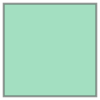

In [3]:
first_polygon = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
first_polygon

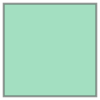

In [4]:
second_polygon = Polygon([(2, -0.5), (3, -0.5), (3, 0.5), (2, 0.5)])
second_polygon

- 将多边形坐标数据转换为matlab中代码需要的struct数据类型和放在matlab中跑出一个结果用来与python跑出的结果进行对比

In [5]:
import scipy.io
first_polygon_x = np.array(first_polygon.boundary.coords)[:, 0].tolist()
first_polygon_y = np.array(first_polygon.boundary.coords)[:, 1].tolist()
scipy.io.savemat('first_polygon.mat', mdict={'x': first_polygon_x, 'y': first_polygon_y})

In [6]:
second_polygon_x = np.array(second_polygon.boundary.coords)[:, 0].tolist()
second_polygon_y = np.array(second_polygon.boundary.coords)[:, 1].tolist()
scipy.io.savemat('second_polygon.mat', mdict={'x': second_polygon_x, 'y': second_polygon_y})

In [7]:
min_dis_second = min_dis_between_two_polygon(first_polygon, second_polygon)
min_dis_second.min_dis_between_polygon()

1.0

- 测试二：两个多边形相互包含

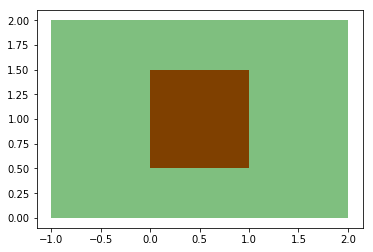

In [9]:
small_polygon = Polygon([(0, 0.5), (1, 0.5), (1, 1.5), (0, 1.5)])
big_polygon = Polygon([(-1, 0), (2, 0), (2, 2), (-1, 2)])
ax = gpd.GeoSeries(small_polygon).plot(color='red')
gpd.GeoSeries(big_polygon).plot(color='green', ax=ax, alpha=0.5)

In [10]:
min_dis_third = min_dis_between_two_polygon(small_polygon, big_polygon)
min_dis_third.min_dis_between_polygon()

0.5